In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
from amb import *
import xarray as xr
import joblib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

## plot boundary probability

In [6]:
def get_all_diff_boundary(ct):
    indir = '/data/female-amb/loop/'
    ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
    ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
    cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'
    
    leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
    bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
    cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
    bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]

    binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
    selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
    selected_bins = selb[selb].index
    #selected_bins = binall.index

    tmp = bound_prob_ct[selected_bins].T
    tmp = tmp[leg]
    tmp.columns = ['8wk','9mo','18mo']
    #tmp = tmp[tmp[f'{ct}.8wk'] < tmp[f'{ct}.18mo']]
    tmp['18mo-8wk'] = tmp['18mo'] - tmp['8wk']
    tmp['celltype'] = ct
    return tmp

In [7]:
allcts = [path.split('/')[-1] for path in glob.glob('/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/*') 
          if path.split('/')[-1] != 'notebooks']

In [8]:
all_df = []
for ct in allcts:
    tmpdf = get_all_diff_boundary(ct)
    all_df.append(tmpdf)

In [15]:
shared_use_cts = joblib.load('/home/qzeng_salk_edu/project/shared_use_cts')
shared_use_cts = [ct.replace('/','').replace(' ','_') for ct in shared_use_cts]

In [17]:
all_df = all_df[all_df['celltype'].isin(shared_use_cts)]

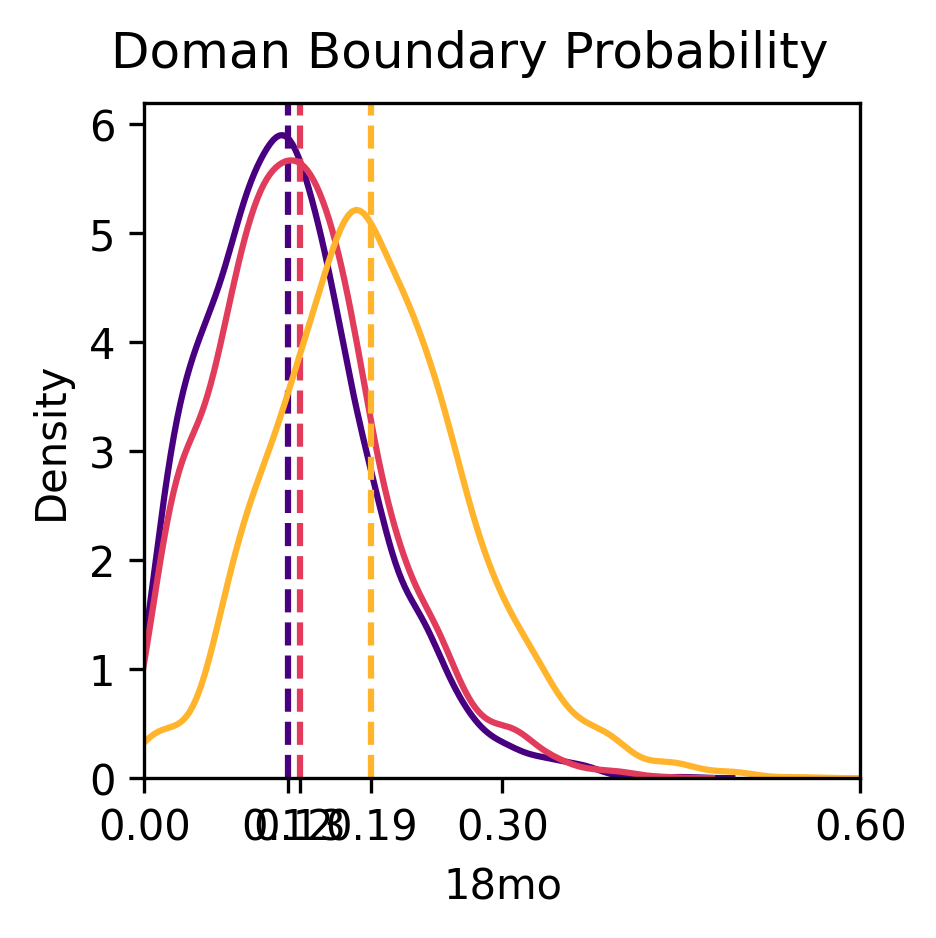

In [22]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 300, constrained_layout = True)

sns.distplot(all_df['8wk'],color = age_palette['2mo'],ax = ax, hist = False)
ax.axvline(x = all_df['8wk'].mean().round(2), c = age_palette['2mo'], ls = '--')
#

sns.distplot(all_df['9mo'], color = age_palette['9mo'], ax = ax, hist = False)
ax.axvline(x = all_df['9mo'].mean().round(2), c = age_palette['9mo'], ls = '--')
#ax.set_xticks([0, all_df['9mo'].mean().round(2), 0.3, 0.6])

sns.distplot(all_df['18mo'],color = age_palette['18mo'],  ax = ax, hist = False)
ax.axvline(x = all_df['18mo'].mean().round(2), c = age_palette['18mo'], ls = '--')
#ax.set_xticks([0, all_df['18mo'].mean().round(2), 0.3, 0.6])
ax.set(xlim=[0, 0.6])
ax.set_xticks([0, all_df['8wk'].mean().round(2), all_df['9mo'].mean().round(2), all_df['18mo'].mean().round(2),0.3, 0.6])

fig.suptitle('Doman Boundary Probability')
fig.savefig(f"figure/OnePlot.Distplot.Boundary.Probability.pdf", bbox_inches = 'tight')

## plot insulation score

In [28]:
def get_all_diff_boundary(ct):
    indir = '/data/female-amb/loop/'
    ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
    
    leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
    
    binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
    selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
    selected_bins = selb[selb].index
    
    ins_count = xr.open_dataset(f'/home/qzeng_salk_edu/project/240205-domain/hicluster_bulk_domain/{ct}.insulation.nc')
    ins_count = ins_count.sel({'bin': (ins_count['bin_chrom']!='chrX')})
    ins_count['ratio'] = (ins_count.sel({'type':'inter'})['__xarray_dataarray_variable__'] / ins_count.sel({'type':'intra'}))['__xarray_dataarray_variable__']
    ins = ins_count['ratio'].to_pandas().loc[leg]
    ins.columns = binall.index

    tmp = ins[selected_bins].T
    tmp = tmp[leg]
    tmp.columns = ['8wk','9mo','18mo']
    #tmp = tmp[tmp[f'{ct}.8wk'] < tmp[f'{ct}.18mo']]
    tmp['18mo-8wk'] = tmp['18mo'] - tmp['8wk']
    tmp['celltype'] = ct
    return tmp

In [29]:
allcts = [path.split('/')[-1] for path in glob.glob('/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/*') 
          if path.split('/')[-1] != 'notebooks']

In [30]:
all_df = []
for ct in allcts:
    tmpdf = get_all_diff_boundary(ct)
    all_df.append(tmpdf)

In [31]:
all_df = pd.concat(all_df)

In [32]:
all_df = all_df[all_df['celltype'].isin(shared_use_cts)]

In [36]:
all_df['18mo'].mean().round(2), all_df['9mo'].mean().round(2), all_df['8wk'].mean().round(2)

(0.15, 0.17, 0.18)

Text(0.5, 0.98, 'Doman Insulation Score')

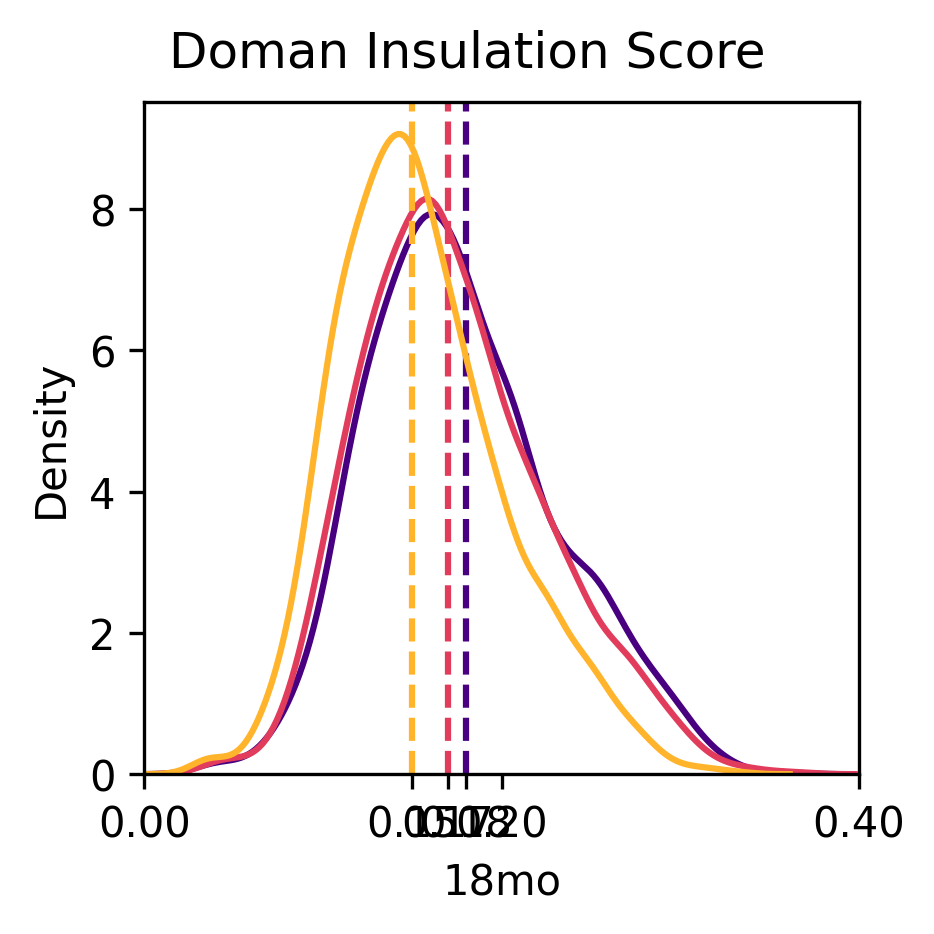

In [35]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 300, constrained_layout = True)

sns.distplot(all_df['8wk'],color = age_palette['2mo'],ax = ax, hist = False)
ax.axvline(x = all_df['8wk'].mean().round(2), c = age_palette['2mo'], ls = '--')
#ax.set_xticks([0, all_df['8wk'].mean().round(2), 0.3, 0.6])

sns.distplot(all_df['9mo'], color = age_palette['9mo'], ax = ax, hist = False)
ax.axvline(x = all_df['9mo'].mean().round(2), c = age_palette['9mo'], ls = '--')
#ax.set_xticks([0, all_df['9mo'].mean().round(2), 0.3, 0.6])

sns.distplot(all_df['18mo'],color = age_palette['18mo'],  ax = ax, hist = False)
ax.axvline(x = all_df['18mo'].mean().round(2), c = age_palette['18mo'], ls = '--')
#ax.set_xticks([0, all_df['18mo'].mean().round(2), 0.3, 0.6])
ax.set_xticks([0, all_df['18mo'].mean().round(2), all_df['9mo'].mean().round(2), all_df['8wk'].mean().round(2),0.2, 0.4])
ax.set(xlim=[0, 0.4])
fig.suptitle('Doman Insulation Score')
#fig.savefig(f"figure/OnePlot.Distplot.Domain.Insulation.pdf", bbox_inches = 'tight')

In [ ]:
all_df['domain_id_celltype'] = all_df.index + '_' + all_df['celltype']

In [ ]:
decrease_db = all_df[all_df['domain_id_celltype'].isin(decrease_domains)]
splitinng_domain = all_df[all_df['domain_id_celltype'].isin(split_domains)]
increase_db = all_df[all_df['domain_id_celltype'].isin(increase_domains)]
decrease_db.shape[0], splitinng_domain.shape[0], increase_db.shape[0]

In [ ]:
fig, axes = plt.subplots(figsize = (9,3), ncols = 3, dpi = 300, constrained_layout = True)

ax = axes[0]
sns.scatterplot(data = all_df,
                ax = ax,
                linewidth = 0,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
                s = 2)
sns.scatterplot(data = decrease_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'blue',
               s = 3)
ax.set(xlim=[0, 0.4], ylim=[0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="grey", ls = '--', lw = 1)
ax.set_title('Decrease Domains')

ax = axes[1]
sns.scatterplot(data = all_df,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
               s = 2)
sns.scatterplot(data = increase_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'red',
               s = 3)
ax.set(xlim=[0, 0.4], ylim=[0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="grey", ls = '--', lw = 1)
ax.set_title('Increase Domains')

ax = axes[2]
sns.scatterplot(data = all_df,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
                color = 'lightgrey',
                s = 2)
sns.scatterplot(data = splitinng_domain,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
                color = 'green',
                s = 3)
ax.set(xlim=[0, 0.4], ylim=[0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="grey", ls = '--', lw = 1)
ax.set_title('Spliting Domains')

fig.suptitle('Domain Insulation Score')
fig.savefig(f"figure/Scatter.Insulation.Score.pdf", bbox_inches = 'tight')

## categorize

In [ ]:
# select 8wk < 0.05 but 18 mo > 0.05

In [ ]:
spliting_domains = all_df[(all_df['8wk'] < 0.05) & (all_df['18mo'] > 0.09) & (all_df['18mo-8wk'] > 0.05)]
spliting_domains = list(set(spliting_domains.index))
len(spliting_domains)

In [ ]:
res = 25000
chroms = [_domain.split('_')[0] for _domain in spliting_domains]
start = [int(_domain.split('_')[1])*res for _domain in spliting_domains]
end = [int(_domain.split('_')[1])*res+res for _domain in spliting_domains]

In [ ]:
spliting_domains_df = pd.DataFrame({'chrom':chroms,'start':start,'end':end}, index =spliting_domains )

In [ ]:
spliting_domains_df.to_csv('spliting_domains.bed', sep = '\t',header = None, index = None)

In [ ]:
spliting_domains_df.to_csv('spliting_domains.csv')

## check cell type

In [ ]:
domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
spliting_domains = domain[(domain['8wk'] < 0.05) & (domain['18mo'] > 0.09) & (domain['18mo-8wk'] > 0.05)]

In [ ]:
res = 25000
gene_intersected = pd.read_csv('split_domain.intersect.gene.bed', sep = '\t', header = None)
gene_intersected['gene_length'] = gene_intersected[2] - gene_intersected[1]
gene_intersected.index = gene_intersected[4] + '_' + (gene_intersected[5]//res).astype(str)

In [ ]:
gene_intersected = gene_intersected[gene_intersected['gene_length'] > 300000]

In [ ]:
shared_domain_b = list(set(use_df.index) & set(domain.index))

In [ ]:
spliting_domains = spliting_domains.loc[shared_domain_b]

In [ ]:
spliting_domains['gene_name'] = use_df[3]
spliting_domains['gene_length'] = use_df['gene_length']

In [ ]:
adeg_result_dir = '/home/qzeng_salk_edu/project/240228_RNA/DEG.stats/'

In [ ]:
all_result = []
for ct, tmpdf in spliting_domains.groupby('celltype'):
    split_genes = tmpdf['gene_name'].tolist()
    try:
        expr = pd.read_hdf(f'{adeg_result_dir}/{ct}/expr.hdf').T
        expr.columns = ['2mo','9mo','18mo']
        expr['celltype'] = ct
        deg_stats = pd.read_hdf(f'{adeg_result_dir}/{ct}/deg_stats.hdf') 
        result = pd.concat([deg_stats.loc[split_genes], expr.loc[split_genes]], axis = 1) 
        all_result.append(result)
    except FileNotFoundError:
        print(ct)
    
all_result = pd.concat(all_result)

In [ ]:
all_result = all_result[all_result['fdr'] < 0.01]

In [ ]:
all_result['18mo-2mo'] = all_result['18mo'] - all_result['2mo']

In [ ]:
sns.distplot(all_result['18mo-2mo'])